In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [2]:
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


In [3]:
%pip install librosa

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [3]:
tf.test.is_gpu_available()

True

In [4]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 1.23.5


In [6]:
%pip install matplotlib seaborn pandas 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
from pathlib import Path
import pandas as pd
import seaborn as sns
# ====== PATHS ======
DATASET_DIR = "for-norm/for-norm"
TRAIN_DIR = os.path.join(DATASET_DIR, "training")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "testing")

In [6]:
def dataset_summary():
    counts = {}
    for split in ["training", "validation", "testing"]:
        print(f"\n--- {split.upper()} ---")
        split_path = os.path.join(DATASET_DIR, split)
        for label in ["real", "fake"]:
            label_path = os.path.join(split_path, label)
            count = len(os.listdir(label_path))
            print(f"{label}: {count} files")
    
dataset_summary()



--- TRAINING ---
real: 26941 files
fake: 26927 files

--- VALIDATION ---
real: 5400 files
fake: 5398 files

--- TESTING ---
real: 2264 files
fake: 2370 files


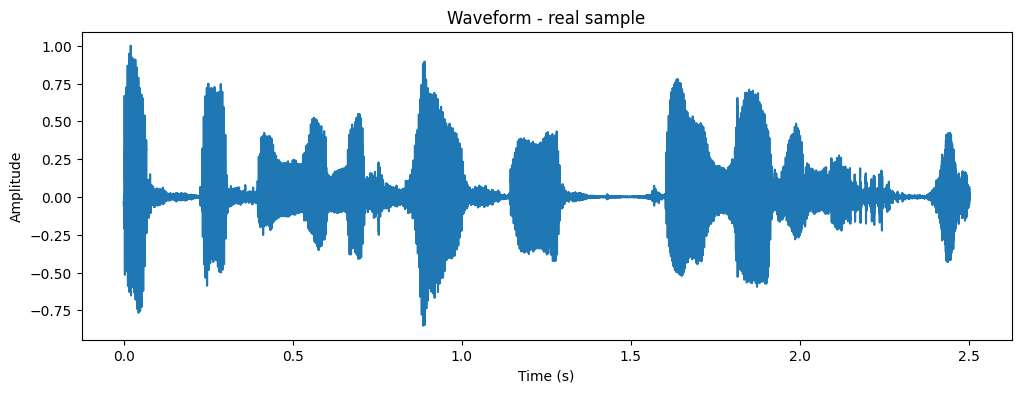

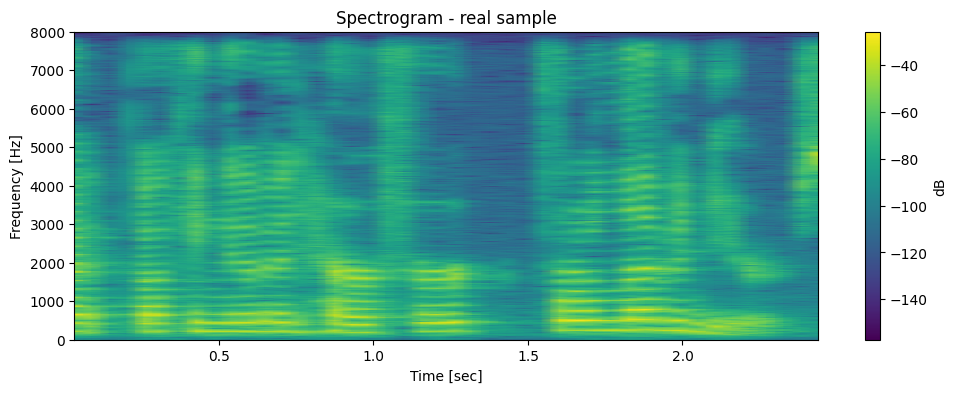

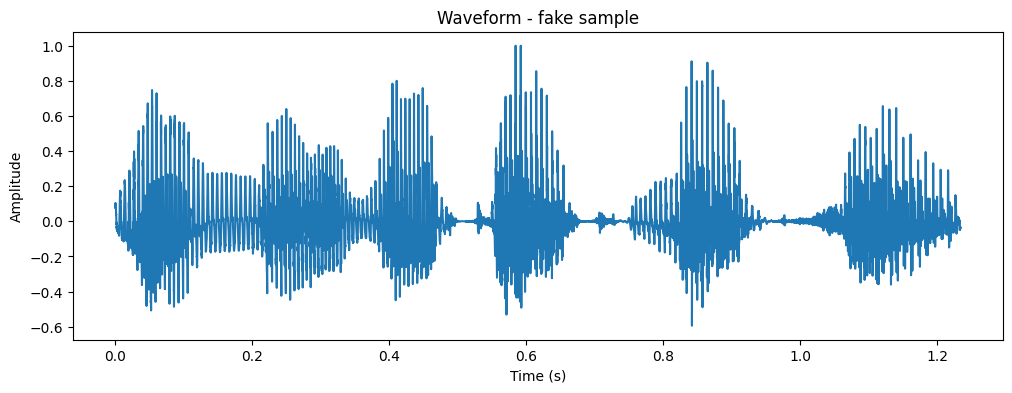

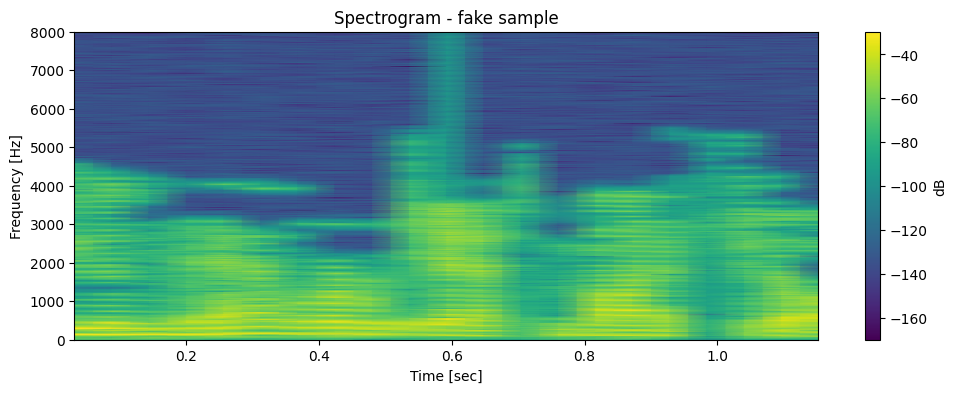

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
from scipy import signal

# ====== Plot Sample Waveform & Spectrogram (without librosa) ======
def plot_sample(label="real"):
    file_path = Path(os.path.join(TRAIN_DIR, label)).glob("*.wav").__next__()

    # Load WAV file
    sr, y = wavfile.read(file_path)

    # If stereo, convert to mono
    if len(y.shape) > 1:
        y = np.mean(y, axis=1)

    # Normalize to [-1, 1]
    y = y / np.max(np.abs(y))

    # ---- Waveform ----
    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, len(y)/sr, num=len(y)), y)
    plt.title(f"Waveform - {label} sample")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # ---- Spectrogram ----
    f, t, Sxx = signal.spectrogram(y, sr, nperseg=1024)
    plt.figure(figsize=(12, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label="dB")
    plt.title(f"Spectrogram - {label} sample")
    plt.show()

# Example usage
plot_sample("real")
plot_sample("fake")


In [8]:
import numpy as np
import librosa
import tensorflow as tf

def preprocess_audio(file_path, duration=5, sr=16000, n_mels=128, fixed_frames=200):
    # Load audio with librosa directly (keeps things simple)
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    
    # Pad/trim to target length
    samples_per_file = sr * duration
    if len(y) > samples_per_file:
        y = y[:samples_per_file]
    else:
        y = np.pad(y, (0, samples_per_file - len(y)))
    
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Fix time frames
    if mel_spec_db.shape[1] > fixed_frames:
        mel_spec_db = mel_spec_db[:, :fixed_frames]
    else:
        mel_spec_db = np.pad(mel_spec_db, ((0,0),(0,fixed_frames - mel_spec_db.shape[1])))

    # Add channel dimension
    mel_spec_db = mel_spec_db[..., np.newaxis]  
    
    return mel_spec_db


In [16]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


Processing fake: 100%|██████████| 26927/26927 [05:43<00:00, 78.43it/s]


Explained variance ratio: [0.50984125 0.12895203]


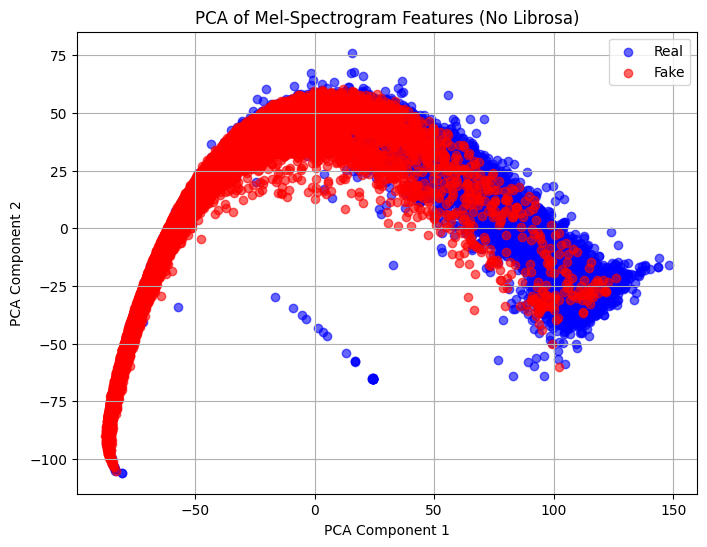

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.io import wavfile
from scipy.signal import spectrogram
from tqdm import tqdm

# ===== PATHS =====
base_dir = "C:/Users/Admin/Desktop/Final Year Innovative Project/for-norm/for-norm"
train_dir = os.path.join(base_dir, "training")

# ===== PARAMETERS =====
sr = 16000
n_mels = 64
duration = 5  # seconds
samples_per_file = sr * duration

# ===== HELPER: Mel filterbank =====
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595.0) - 1)

def mel_filterbank(n_filters, n_fft, sr):
    # Build triangular mel filterbank
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sr / 2)
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    fbanks = np.zeros((n_filters, n_fft // 2 + 1))
    for i in range(1, n_filters + 1):
        left, center, right = bin_points[i-1], bin_points[i], bin_points[i+1]
        for j in range(left, center):
            fbanks[i-1, j] = (j - left) / (center - left)
        for j in range(center, right):
            fbanks[i-1, j] = (right - j) / (right - center)
    return fbanks

# Precompute mel filterbank
n_fft = 1024
mel_fbanks = mel_filterbank(n_mels, n_fft, sr)

# ===== FEATURE EXTRACTION =====
X_features = []
y_labels = []

for label in ["real", "fake"]:
    folder_path = os.path.join(train_dir, label)
    for file_name in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        file_path = os.path.join(folder_path, file_name)
        try:
            # Load audio
            rate, y = wavfile.read(file_path)
            if len(y.shape) > 1:  # stereo → mono
                y = np.mean(y, axis=1)
            y = y.astype(np.float32)

            # Resample if needed
            if rate != sr:
                continue  # skip for simplicity (or resample with scipy.signal.resample)

            # Pad/trim
            if len(y) > samples_per_file:
                y = y[:samples_per_file]
            else:
                y = np.pad(y, (0, samples_per_file - len(y)))

            # Spectrogram
            f, t, Sxx = spectrogram(y, fs=sr, nperseg=n_fft, noverlap=n_fft//2, scaling='spectrum')
            Sxx = Sxx[:n_fft//2+1]  # keep positive freqs

            # Apply mel filterbank
            mel_spec = np.dot(mel_fbanks, Sxx)

            # Log scale
            mel_spec_db = 10 * np.log10(np.maximum(mel_spec, 1e-10))

            # Flatten
            mel_flat = mel_spec_db.flatten()
            X_features.append(mel_flat)
            y_labels.append(0 if label == "real" else 1)

        except Exception as e:
            print(f"Error with file {file_name}: {e}")

# ===== CONVERT TO ARRAYS =====
X_features = np.array(X_features)
y_labels = np.array(y_labels)

# ===== STANDARDIZE + PCA =====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# ===== PLOT =====
plt.figure(figsize=(8, 6))
for class_value, class_name, color in zip([0, 1], ["Real", "Fake"], ["blue", "red"]):
    plt.scatter(X_pca[y_labels == class_value, 0],
                X_pca[y_labels == class_value, 1],
                label=class_name, alpha=0.6, c=color)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Mel-Spectrogram Features (No Librosa)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# PCA Results
print("Number of components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print("Explained variance (eigenvalues):", pca.explained_variance_)
print("PCA components (eigenvectors):\n", pca.components_)
print("PCA mean (per feature):\n", pca.mean_)
print("Shape of transformed data:", X_pca.shape)


Number of components: 2
Explained variance ratio: [0.50984125 0.12895203]
Cumulative explained variance: [0.50984125 0.63879328]
Explained variance (eigenvalues): [5057.71910112 1279.22786382]
PCA components (eigenvectors):
 [[-0.00397036 -0.00374785 -0.00375548 ...  0.01086758  0.01080451
   0.01074813]
 [ 0.00553181  0.00566218  0.0060206  ... -0.01103701 -0.01098907
  -0.0109377 ]]
PCA mean (per feature):
 [-2.73434980e-15 -1.96548573e-14 -2.46304095e-14 ... -4.44444424e-14
 -1.44607417e-13 -8.85511127e-14]
Shape of transformed data: (53868, 2)


In [16]:
%pip install scikit-learn umap-learn seaborn


Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import wavfile
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Feature Extraction (MFCC)
# -----------------------------

def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595.0) - 1)

def mel_filterbank(n_filters, n_fft, sr):
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sr/2)
    mel_points = np.linspace(low_mel, high_mel, n_filters+2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft+1) * hz_points / sr).astype(int)

    fbanks = np.zeros((n_filters, n_fft//2+1))
    for i in range(1, n_filters+1):
        left, center, right = bin_points[i-1], bin_points[i], bin_points[i+1]
        for j in range(left, center):
            fbanks[i-1, j] = (j-left)/(center-left)
        for j in range(center, right):
            fbanks[i-1, j] = (right-j)/(right-center)
    return fbanks

def extract_features(file_path, sr=16000, n_mfcc=40, n_mels=64, max_pad_len=200, n_fft=512, hop_length=256):
    try:
        if os.path.getsize(file_path) < 1024:  # skip tiny files
            return None

        rate, audio = wavfile.read(file_path)
        if len(audio.shape) > 1:  # stereo → mono
            audio = np.mean(audio, axis=1)
        audio = audio.astype(np.float32)

        if rate != sr:
            return None  # (or resample with scipy.signal.resample)

        # Frame & FFT
        window = np.hamming(n_fft)
        frames = []
        for i in range(0, len(audio)-n_fft, hop_length):
            frame = audio[i:i+n_fft] * window
            spectrum = np.fft.rfft(frame, n_fft)
            power = (1.0 / n_fft) * (np.abs(spectrum) ** 2)
            frames.append(power)
        frames = np.array(frames).T  # shape: (freq, time)

        # Mel filterbank
        fbanks = mel_filterbank(n_mels, n_fft, sr)
        mel_spec = np.dot(fbanks, frames)

        # log-mel
        mel_spec = np.where(mel_spec == 0, np.finfo(float).eps, mel_spec)  # avoid log(0)
        log_mel = np.log(mel_spec)

        # MFCC (DCT on log-mel)
        mfcc = dct(log_mel, type=2, axis=0, norm='ortho')[0:n_mfcc, :]

        # Pad/truncate
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        return mfcc.astype(np.float32)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset(base_dir, max_pad_len=200):
    X, y = [], []
    for label, category in enumerate(["real", "fake"]):
        folder = os.path.join(base_dir, category)
        for file in tqdm(os.listdir(folder), desc=f"Processing {category}"):
            file_path = os.path.join(folder, file)
            if file.endswith(".wav"):
                features = extract_features(file_path, max_pad_len=max_pad_len)
                if features is not None:
                    X.append(features)
                    y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

# -----------------------------
# 2. Load Dataset
# -----------------------------
train_dir = "for-norm/for-norm/training"
X, y = load_dataset(train_dir)

print("Feature matrix shape:", X.shape)   # (samples, 40, 200)
print("Labels shape:", y.shape)

# Save preprocessed dataset
np.save("X_features.npy", X)
np.save("y_labels.npy", y)

# -----------------------------
# 3. Prepare Data for Training
# -----------------------------
X = np.expand_dims(X, -1)  # CNN input

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

# -----------------------------
# 4. Build Model (CNN + BiLSTM)
# -----------------------------
def build_model(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    # Flatten CNN output but keep time axis
    model.add(layers.Reshape((model.output_shape[1]*model.output_shape[2], model.output_shape[3])))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)
    return model

input_shape = X_train.shape[1:]  # (40,200,1)
model = build_model(input_shape)
model.summary()

# -----------------------------
# 5. Train Model
# -----------------------------
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[callback],
    verbose=1
)

# -----------------------------
# 6. Evaluate
# -----------------------------
results = model.evaluate(X_val, y_val, verbose=0)

# Map results to metric names
metrics_dict = dict(zip(model.metrics_names, results))

print("Validation Results:")
for k, v in metrics_dict.items():
    print(f"{k}: {v:.4f}")

Processing fake: 100%|██████████| 26927/26927 [04:44<00:00, 94.54it/s] 


Feature matrix shape: (53866, 40, 200)
Labels shape: (53866,)
Train shape: (43092, 40, 200, 1)
Validation shape: (10774, 40, 200, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 198, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 38, 198, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 97, 64)        

In [12]:
model.save("audio_classification_model.h5")

In [13]:
# Single File Prediction

test_file = r"C:\Users\Admin\Desktop\Final Year Innovative Project\for-norm\for-norm\testing\fake\file4.wav_16k.wav_norm.wav_mono.wav_silence.wav"

features = extract_features(test_file, max_pad_len=200)  # same as training
if features is not None:
    features = np.expand_dims(features, axis=-1)   # (40,200,1)
    features = np.expand_dims(features, axis=0)    # (1,40,200,1) → batch size 1

    prediction = model.predict(features)
    pred_label = "FAKE" if prediction[0][0] > 0.15 else "REAL"

    print(f"Prediction for {os.path.basename(test_file)}: {pred_label} (score={prediction[0][0]:.4f})")
else:
    print("Could not extract features from the test file.")

1/1 [==============================] - 1s 725ms/step
Prediction for file4.wav_16k.wav_norm.wav_mono.wav_silence.wav: FAKE (score=0.9160)


In [15]:
# Single File Prediction

test_file = r"C:\Users\Admin\Desktop\Final Year Innovative Project\for-norm\for-norm\testing\real\file8.wav_16k.wav_norm.wav_mono.wav_silence.wav"

features = extract_features(test_file, max_pad_len=200)  # same as training
if features is not None:
    features = np.expand_dims(features, axis=-1)   # (40,200,1)
    features = np.expand_dims(features, axis=0)    # (1,40,200,1) → batch size 1

    prediction = model.predict(features)
    pred_label = "FAKE" if prediction[0][0] > 0.15 else "REAL"

    print(f"Prediction for {os.path.basename(test_file)}: {pred_label} (score={prediction[0][0]:.4f})")
else:
    print("Could not extract features from the test file.")

1/1 [==============================] - 0s 35ms/step
Prediction for file8.wav_16k.wav_norm.wav_mono.wav_silence.wav: REAL (score=0.0000)
